<a href="https://colab.research.google.com/github/davidvlaminck/AWVGeneric/blob/1-get-documents-linked-to-order/UseCases/SearchDocumentsFromAssets/documenten_ophalen_obv_dossiernummer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documenten ophalen op basis van dossiernummer

Met deze notebook kunt u alle documenten ophalen die gelinkt zijn aan een dossiernummer.

Als invoer dient u een **dossiernunmmer** en de **document types** op te geven.
Bijkomend kunt u filteren op de naam van één **toezichthouder**, alsook op 1 of meerdere **provincies**.

Als resultaat krijgt U een .zip-folder terug,  met daarin de documenten en een Excel-overzicht. De structuur van de .zip folder is als volgt:

folder.zip >> [provincie] >> [toezichter] >> [naampad] >> [document_type]

Achterliggend wordt gebruik gemaakt van de [EM-Infra API](https://apps.mow.vlaanderen.be/eminfra/core/swagger-ui/).

Voer onderstaand script uit om de GitHub repo te clonen, door op de play-knop 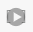
aan de linkerzijde te klikken

In [1]:
import os, shutil
import sys
if os.path.exists('AWVGeneric'):
  shutil.rmtree('AWVGeneric')
!git clone https://github.com/davidvlaminck/AWVGeneric.git -b '1-get-documents-linked-to-order'
sys.path.insert(0, '/content/AWVGeneric')  # adds the Python files from the GitHub repo to the sys-path.

Cloning into 'AWVGeneric'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 407 (delta 110), reused 120 (delta 78), pack-reused 243 (from 1)
Receiving objects: 100% (407/407), 573.05 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [2]:
import shutil
import tempfile
from datetime import datetime

import pandas as pd
import re

from API.EMInfraClient import EMInfraClient
from API.EMInfraDomain import DocumentCategorieEnum, QueryDTO, PagingModeEnum, SelectionDTO, ExpressionDTO, TermDTO, \
    OperatorEnum, ExpansionsDTO, construct_naampad, LogicalOpEnum, ApplicationEnum, ProvincieEnum
from pathlib import Path
from API.Enums import AuthType, Environment
from Generic.ExcelModifier import ExcelModifier

def download_documents(eminfra_client, edelta_dossiernummer: str, document_categorie:[DocumentCategorieEnum], toezichter:str = None, provincie:[ProvincieEnum] = None):
    """Download documents

    Downloading documents from EM-Infra based on the criteria:
        edelta_dossiernummer, document_categorien, toezichter (optional), provincie (optional)

    :param eminfra_client: EMInfraClient Client voor de authenticatie met EM-Infra
    :param edelta_dossiernummer: str Dossiernummer
    :param document_categorie: [DocumentCategorieEnum] Lijst van Document categoriën
    :param toezichter: str Naam van de toezichter
    :param provincie: [ProvincieEnum] Lijst van provincienamen
    """
    provincie_value = [item.value for item in provincie] if provincie else provincie
    document_categorie_value = [item.value for item in document_categorien]
    print(f'Ophalen van alle documenten die voldoen aan volgende criteria:'
          f'\tDocument categorie: {document_categorie_value}'
          f'\tDossiernummer: {edelta_dossiernummer}'
          f'\tToezichter: {toezichter}'
          f'\tProvincie: {provincie_value}')

    bestek_ref = eminfra_client.get_bestekref_by_eDelta_dossiernummer(edelta_dossiernummer)
    bestek_ref_uuid = bestek_ref[0].uuid

    # build query to search assets linked with an order (NL: bestek)
    query_dto_search_assets = QueryDTO(
        size=5,
        from_=0,
        pagingMode=PagingModeEnum.OFFSET,
        selection=SelectionDTO(
            expressions=[
                ExpressionDTO(
                    terms=[
                        TermDTO(
                            property='actiefBestek',
                            operator=OperatorEnum.EQ,
                            value=f'{bestek_ref_uuid}',
                            logicalOp=None)]
                )]
        )
        , expansions=ExpansionsDTO(
            fields=["parent", "kenmerk:f0166ba2-757c-4cf3-bf71-2e4fdff43fa3"])
    )

    # Append "toezichter" to the search-query
    if toezichter:
        # Voeg álle toezichters toe in de zoekopdracht
        identiteiten = eminfra_client.search_identiteit(naam=toezichter)
        identiteiten_uuid = [identiteit.uuid for identiteit in identiteiten]
        query_dto_search_assets.selection.expressions[0].terms.append(
            TermDTO(property='toezichter',operator=OperatorEnum.IN,value=identiteiten_uuid,logicalOp=LogicalOpEnum.AND)
        )

    # Append "provincie" to the search-query
    if provincie_value:
        query_dto_search_assets.selection.expressions[0].terms.append(
            TermDTO(
                property='locatieProvincie',operator=OperatorEnum.IN,value=provincie_value,logicalOp=LogicalOpEnum.AND)
        )

    # build query to download documents
    query_dto_search_document = QueryDTO(
        size=100
        , from_=0
        , pagingMode=PagingModeEnum.OFFSET
        , selection=SelectionDTO(
            expressions=[ExpressionDTO(
                terms=[TermDTO(property='categorie',operator=OperatorEnum.IN,value=document_categorie_value)]
            )]
        )
    )

    # Create temporary folder, download all files, write an overview in an Excel file and zip all results to an output folder (Downloads).
    downloads_path = Path.home() / 'Downloads' / 'Results'
    print("Downloading documents...")

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)

        asset_bucket_generator = eminfra_client.search_all_assets(query_dto_search_assets)

        # Store assets in a pandas dataframe
        df_assets = pd.DataFrame(
            columns=["uuid", "assettype", "naam", "naampad", "actief", "toestand",
                     "toezichter_naam", "toezichter_voornaam", "provincie", "gemeente",
                     "document_categorie", "document_naam", "document_uuid"])

        start_time = datetime.now()
        for i, asset in enumerate(asset_bucket_generator):
            # Track progress
            if i % 10 == 0:
                elapsed = datetime.now() - start_time
                print(f"Processed {i} assets in {elapsed.total_seconds():.2f} seconds")

            # locatiekenmerk
            locatiekenmerk = eminfra_client.get_kenmerk_locatie_by_asset_uuid(asset.uuid)
            if locatiekenmerk.locatie.get('adres'):  # Skip when locatiekenmerk.locatie is None
                locatie_adres = locatiekenmerk.locatie.get('adres')
                locatie_gemeente = locatie_adres.get('gemeente')
                if locatie_gemeente is None:
                    locatie_gemeente = 'ongekend'
                locatie_provincie = locatie_adres.get('provincie')
                if locatie_provincie is None:
                    locatie_provincie = 'ongekend'


            # identiteitkenmerk (toezichter)
            toezichter_uuid = asset.kenmerken.get('data')[0].get('toezichter').get('uuid')
            identiteit_kenmerk = eminfra_client.get_identiteit(toezichter_uuid)
            toezichter_naam = identiteit_kenmerk.naam
            toezichter_voornaam = identiteit_kenmerk.voornaam
            toezichter_volledige_naam = f'{toezichter_naam}_{toezichter_voornaam}'

            naampad = construct_naampad(asset)

            documents = eminfra_client.search_documents_by_asset_uuid(
                asset_uuid=asset.uuid
                , query_dto=query_dto_search_document
            )

            for document in documents:
                row_dict = {
                    'uuid': asset.uuid
                    , 'assettype': asset.type.afkorting
                    , 'naam': asset.naam
                    , 'naampad': naampad
                    , 'actief': asset.actief
                    , 'toestand': asset.toestand.value
                    , 'toezichter_naam': toezichter_naam
                    , 'toezichter_voornaam': toezichter_voornaam
                    , 'provincie': locatie_provincie
                    , 'gemeente': locatie_gemeente
                    , 'document_categorie': document.categorie.value
                    , 'document_naam': document.naam
                    , 'document_uuid': document.uuid
                    }

                row_df = pd.DataFrame([row_dict])
                df_assets = pd.concat([df_assets, row_df], ignore_index=True)

                # Write document to temp_dir
                eminfra_client.download_document(
                    document=document
                    , directory=temp_path / locatie_provincie / toezichter_volledige_naam / naampad.replace('/', '__') / document.categorie.value
                )

        # Write overview
        edelta_dossiernummer_str = re.sub('[^0-9a-zA-Z]+', '_', edelta_dossiernummer)  # replace all non-alphanumeric characters with an underscore
        output_file_path_excel = temp_path / 'overzicht.xlsx'
        df_assets.to_excel(excel_writer=output_file_path_excel
                           , sheet_name=edelta_dossiernummer_str
                           , index=False
                           , engine="openpyxl")

        excelModifier = ExcelModifier(output_file_path_excel)
        excelModifier.add_hyperlink(sheet=edelta_dossiernummer_str, link_type=ApplicationEnum.EM_INFRA, env=Environment.PRD)

        # Zip the output folder. Temp folder is automatically removed
        zip_path = downloads_path / f'documenten_{edelta_dossiernummer_str}'  # The output path of the zip file (without extension)
        shutil.make_archive(str(zip_path), 'zip', root_dir=str(temp_dir))
        print(f"Folder {temp_dir} has been zipped to {zip_path}.zip.")

Vul een dossiernummer in en lanceer de code via de play-knop.

In [ ]:
# edelta_dossiernummer
edelta_dossiernummer = 'VWT/DVM/2023/3'
print(f'Het gekozen dossiernummer is: {edelta_dossiernummer}')

Vul één of meerdere documentcategoriën in en lanceer de code via de play-knop.

In [6]:
# document_categorien
print(f'De mogelijke document categoriën zijn: {[item.value for item in DocumentCategorieEnum]}')
document_categorien = [DocumentCategorieEnum.KEURINGSVERSLAG, DocumentCategorieEnum.ELEKTRISCH_SCHEMA]
print(f'De gekozen document categoriën zijn: {[item.value for item in document_categorien]}')

De mogelijke document categoriën zijn: ['AANGEBODEN_SERVICES', 'ANDER', 'ASBUILT_DOSSIER', 'BEREKENINGSNOTA', 'BRIEF', 'CONFIGBESTAND', 'CONSTRUCTIE_EN_MONTAGEPLAN', 'CONTROLEMETING_EBS', 'DIMCONFIGURATIE', 'ELEKTRISCH_SCHEMA', 'FACTUUR', 'FOTO', 'HANDLEIDING', 'INTERVENTIEVERSLAG', 'KABELAANSLUITSCHEMA', 'KEURINGSVERSLAG', 'LICHTSTUDIE', 'LUSSENMEETRAPPORT', 'MEETRAPPORT', 'M_PLAN', 'OFFERTE', 'OPROEPDOCUMENT', 'PV_INGEBREKESTELLING', 'PV_OPLEVERING', 'PV_SCHADEVERWEKKER', 'RISICOANALYSE', 'SOFTWARE_DEPENDENCIES', 'TECHNISCHE_FICHE', 'TRACO_ATTEST', 'V_PLAN']
De gekozen document categoriën zijn: ['KEURINGSVERSLAG', 'ELEKTRISCH_SCHEMA']


Vul een toezichter in en lanceer de code via de play-knop (optioneel)

In [7]:
# toezichter
toezichter = 'Stefan Missotten'
print(f'De gekozen toezichter luidt: {toezichter}')

De gekozen toezichter luidt: Stefan Missotten


Vul één of meerdere provincies in en lanceer de code via de play-knop (optioneel)

In [9]:
# provincie
print(f'De mogelijke provincies zijn: {[item.value for item in ProvincieEnum]}')
provincie = [ProvincieEnum.OOST_VLAANDEREN, ProvincieEnum.VLAAMS_BRABANT]
print(f'De gekozen provincies zijn: {[item.value for item in provincie]}')

De mogelijke provincies zijn: ['antwerpen', 'west-vlaanderen', 'oost-vlaanderen', 'vlaams-brabant', 'limburg', 'brussel']
De gekozen provincies zijn: ['oost-vlaanderen', 'vlaams-brabant']


Haal een cookie op.
Met behulp van de cookie, kan je verbinding maken met de data van em-infra. Een cookie blijft geldig voor 1 dag.


1.   Verbind met de applicatie [elisa-infra](https://apps.mow.vlaanderen.be/awvinfra/ui/). Eventueel heb je ItsMe nodig.
2.   Druk op de toets F12. Nu zie je wat er zich achterliggend deze website afspeelt.
3.   Klik door naar het menu **Network**
4.   Selecteer een willekeurig object op de kaart.
5.   Klik op de laatste call en selecteer het menu **Headers**
6.   Kopieer de code na **acm-awv=**. Dit is de cookie.
7.   Lanceer onderstaande code

In [ ]:
awv_acm_cookie = 'f08ac55a59af4fcf8bd923bf388598ed'  # 15/01/2025
eminfra_client = EMInfraClient(cookie=awv_acm_cookie, auth_type=AuthType.COOKIE, env=Environment.PRD)

Lanceer de functie om alle documenten te downloaden.

In [ ]:
download_documents(eminfra_client=eminfra_client, edelta_dossiernummer=edelta_dossiernummer,
                    document_categorie=document_categorien, provincie=provincie, toezichter=toezichter)

De mogelijke document categoriën zijn: ['AANGEBODEN_SERVICES', 'ANDER', 'ASBUILT_DOSSIER', 'BEREKENINGSNOTA', 'BRIEF', 'CONFIGBESTAND', 'CONSTRUCTIE_EN_MONTAGEPLAN', 'CONTROLEMETING_EBS', 'DIMCONFIGURATIE', 'ELEKTRISCH_SCHEMA', 'FACTUUR', 'FOTO', 'HANDLEIDING', 'INTERVENTIEVERSLAG', 'KABELAANSLUITSCHEMA', 'KEURINGSVERSLAG', 'LICHTSTUDIE', 'LUSSENMEETRAPPORT', 'MEETRAPPORT', 'M_PLAN', 'OFFERTE', 'OPROEPDOCUMENT', 'PV_INGEBREKESTELLING', 'PV_OPLEVERING', 'PV_SCHADEVERWEKKER', 'RISICOANALYSE', 'SOFTWARE_DEPENDENCIES', 'TECHNISCHE_FICHE', 'TRACO_ATTEST', 'V_PLAN']
De mogelijke provincies zijn: ['antwerpen', 'west-vlaanderen', 'oost-vlaanderen', 'vlaams-brabant', 'limburg', 'brussel']
Ophalen van alle documenten die voldoen aan volgende criteria:	Document categorie: ['KEURINGSVERSLAG', 'ELEKTRISCH_SCHEMA']	Dossiernummer: VWT/DVM/2023/3	Toezichter: Stefan Missotten	Provincie: None
[{'uuid': '1fa467bc-1917-44d2-83f0-201e51d1876a', 'awvId': '0533089e-4c39-3f5e-8e96-3ea24256d148', 'eDeltaDossie

In [3]:
awv_acm_cookie = 'f08ac55a59af4fcf8bd923bf388598ed'  # 15/01/2025
eminfra_client = EMInfraClient(cookie=awv_acm_cookie, auth_type=AuthType.COOKIE, env=Environment.PRD)

# edelta_dossiernummer
edelta_dossiernummer = 'VWT/DVM/2023/3'

# document_categorien
document_categorien = [DocumentCategorieEnum.KEURINGSVERSLAG, DocumentCategorieEnum.ELEKTRISCH_SCHEMA]
print(f'De mogelijke document categoriën zijn: {[item.value for item in DocumentCategorieEnum]}')

# toezichter
toezichter = 'Stefan Missotten'

# provincie
print(f'De mogelijke provincies zijn: {[item.value for item in ProvincieEnum]}')
# provincie = [ProvincieEnum.OOST_VLAANDEREN, ProvincieEnum.VLAAMS_BRABANT]
provincie = None

download_documents(eminfra_client=eminfra_client, edelta_dossiernummer=edelta_dossiernummer,
                    document_categorie=document_categorien, provincie=provincie, toezichter=toezichter)

De mogelijke document categoriën zijn: ['AANGEBODEN_SERVICES', 'ANDER', 'ASBUILT_DOSSIER', 'BEREKENINGSNOTA', 'BRIEF', 'CONFIGBESTAND', 'CONSTRUCTIE_EN_MONTAGEPLAN', 'CONTROLEMETING_EBS', 'DIMCONFIGURATIE', 'ELEKTRISCH_SCHEMA', 'FACTUUR', 'FOTO', 'HANDLEIDING', 'INTERVENTIEVERSLAG', 'KABELAANSLUITSCHEMA', 'KEURINGSVERSLAG', 'LICHTSTUDIE', 'LUSSENMEETRAPPORT', 'MEETRAPPORT', 'M_PLAN', 'OFFERTE', 'OPROEPDOCUMENT', 'PV_INGEBREKESTELLING', 'PV_OPLEVERING', 'PV_SCHADEVERWEKKER', 'RISICOANALYSE', 'SOFTWARE_DEPENDENCIES', 'TECHNISCHE_FICHE', 'TRACO_ATTEST', 'V_PLAN']
De mogelijke provincies zijn: ['antwerpen', 'west-vlaanderen', 'oost-vlaanderen', 'vlaams-brabant', 'limburg', 'brussel']
Ophalen van alle documenten die voldoen aan volgende criteria:	Document categorie: ['KEURINGSVERSLAG', 'ELEKTRISCH_SCHEMA']	Dossiernummer: VWT/DVM/2023/3	Toezichter: Stefan Missotten	Provincie: None
[{'uuid': '1fa467bc-1917-44d2-83f0-201e51d1876a', 'awvId': '0533089e-4c39-3f5e-8e96-3ea24256d148', 'eDeltaDossie

U kunt de resultaten in de folder **Result** terugvinden, in het linker menu.